## Агентство недвижимости
### К вам обратился представитель крупного агентства недвижимости со следующей проблемой:
### «Мои риелторы тратят катастрофически много времени на сортировку объявлений и поиск выгодных предложений. Поэтому их скорость реакции, да и, сказать по правде, качество анализа не дотягивают до уровня конкурентов. Это сказывается на наших финансовых показателях.
### Ваша задача — разработать модель, которая позволила бы обойти конкурентов по скорости и качеству совершения сделок
### Что необходимо сделать: разработать сервис для предсказания стоимости домов на основе истории предложений

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from scipy import stats
from sklearn import linear_model #линейные модели
from sklearn import preprocessing #предобработка
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics #метрики
from sklearn.model_selection import cross_val_score
import lightgbm as lgm
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn import cluster
from sklearn import feature_selection
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor)
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.metrics import (mean_squared_error, mean_absolute_error)
import xgboost
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
%matplotlib inline
plt.style.use('seaborn')

/tmp/ipykernel_35734/2171165445.py:28: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
data = pd.read_csv("data.csv/data.csv")
data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


## Данные о недвижимости:

- status (статус недвижимости);
- propertyType (тип жилья);
- street (адрес,название улицы);
- baths (количество ванных комнат);
- homeFacts (данные по дому);
- city (город в котором находится недвижимость);
- schools (школа);
- sqft (размер недвижимости);
- zipcode (почтовый адрес);
- beds (количество кроватей);
- state (штат США в котором находится недвижимость);
- MlsId (идентификационный номер MLS риэлтора совпадает с идентификатором имени пользователя или идентификатором входа в систему);

## Другие данные:

- private pool (частный бассейн);
- fireplace (камин);
- mls-id (млс-идентификатор);
- PrivatePool (Частный бассейн);
- stories (история,популярность в соцсетях);

## Целевой признак:

- target.

### Так данные у нас размечены и наша задача предсказать число (предсказать стоимость домов) в машинном обучении мы будем использовать обучение с учителем - регрессия

<img src="https://lms.skillfactory.ru/assets/courseware/v1/555ac515171ab695b3f02b3faae9779b/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst3-ml1-3_1.png">

# 1. Проведем исследование структуры данных
### Выведем информацию о числе непустых значений.

### Начнём с поиска дубликатов в данных. Найдите все повторяющиеся строки в данных и удалите их. Для поиска используйте все признаки в данных. Сколько записей осталось в данных?

In [3]:
dupl_columns = list(data.columns)
mask = data.duplicated(subset=dupl_columns)
data_duplicates = data[mask]
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')
data_dedupped = data.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {data_dedupped.shape[0]}')

Число найденных дубликатов: 50
Результирующее число записей: 377135


### Найдем все неинформативные признаки в данных и избавимся от них. В качестве порога информативности возьмем 0.4: удалим все признаки, для которых 40 % значений повторяются или 40 % записей уникальны. В ответ запишим имена признаков, которые мы нашли

In [4]:
#список неинформативных признаков
low_information_cols = [] 

#цикл по всем столбцам
for col in data.columns:
    #наибольшая относительная частота в признаке
    top_freq = data[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = data[col].nunique() / data_dedupped[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.4:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.4:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

status: 46.28% одинаковых значений
private pool: 100.0% одинаковых значений
street: 89.38% уникальных значений
homeFacts: 85.12% уникальных значений
fireplace: 48.83% одинаковых значений
schools: 78.85% уникальных значений
mls-id: 99.86% уникальных значений
PrivatePool: 71.43% одинаковых значений
MlsId: 75.08% уникальных значений


In [5]:
information_data = data.drop(low_information_cols, axis=1)
print(f'Результирующее число признаков: {information_data.shape[1]}')

Результирующее число признаков: 9


In [6]:
information_data.head()

,propertyType,baths,city,sqft,zipcode,beds,state,stories,target
0,Single Family Home,3.5,Southern Pines,2900,28387,4,NC,NaN,"$418,000"
1,single-family home,3 Baths,Spokane Valley,"1,947 sqft",99216,3 Beds,WA,2.0,"$310,000"
2,single-family home,2 Baths,Los Angeles,"3,000 sqft",90049,3 Beds,CA,1.0,"$2,895,000"
3,single-family home,8 Baths,Dallas,"6,457 sqft",75205,5 Beds,TX,3.0,"$2,395,000"
4,lot/land,NaN,Palm Bay,NaN,32908,NaN,FL,NaN,"$5,000"


### Посмотрим на пропуски

In [7]:
information_data.isna().sum()

propertyType     34733
baths           106338
city                34
sqft             40577
zipcode              0
beds             91282
state                0
stories         150715
target            2481
dtype: int64

### Попробуем найти пропуски в данных с помощью метода insull(). Спойлер: ничего не найдём,а они есть! Просто они скрыты от наших глаз. В таблице пропуски в столбцах propertyType, baths, city, beds, sqft, stories и target обозначены нулём, поэтому традиционные методы поиска пропусков ничего нам не покажут. Сейчас мы это исправим! Заменим все записи, равные 0, в столбцах propertyType, baths, city, beds, sqft, stories и target на символ пропуска. Его мы можем взять из библиотеки numpy: np.nan. 

In [8]:
data_col_list=['propertyType', 'baths', 'city', 'sqft', 'beds', 'stories', 'target']
for col in data_col_list:
    information_data[col]=information_data[col].apply(lambda x: np.nan if x==0 else x)
print(information_data.isnull().mean()) 

propertyType    0.092085
baths           0.281925
city            0.000090
sqft            0.107579
zipcode         0.000000
beds            0.242009
state           0.000000
stories         0.399578
target          0.006578
dtype: float64


### Удалим из данных признаки, где число пропусков составляет более 30 %

In [9]:
drop_data = information_data.copy()
parameters = drop_data.shape[0]*0.7
drop_data = drop_data.dropna(thresh=parameters, axis=1)
print(drop_data.shape[1])

8


In [10]:
drop_data.head()

,propertyType,baths,city,sqft,zipcode,beds,state,target
0,Single Family Home,3.5,Southern Pines,2900,28387,4,NC,"$418,000"
1,single-family home,3 Baths,Spokane Valley,"1,947 sqft",99216,3 Beds,WA,"$310,000"
2,single-family home,2 Baths,Los Angeles,"3,000 sqft",90049,3 Beds,CA,"$2,895,000"
3,single-family home,8 Baths,Dallas,"6,457 sqft",75205,5 Beds,TX,"$2,395,000"
4,lot/land,NaN,Palm Bay,NaN,32908,NaN,FL,"$5,000"


# Категория propertyType (тип жилья)
### Сделаем предобработку и выведем топ 10 самых популярных значения propertyType

In [11]:
dpT = drop_data.copy()

In [12]:
dpT['propertyType'] = dpT['propertyType'].apply(lambda x: str(x).lower())
print(dpT['propertyType'].value_counts().head(10))

print('Количество уникальных значений:',dpT['propertyType'].nunique())

single-family home               92206
single family                    62869
condo                            42529
nan                              34733
single family home               31728
lot/land                         20552
townhouse                        18400
land                             10934
multi-family                      7921
condo/townhome/row home/co-op     7701
Name: propertyType, dtype: int64
Количество уникальных значений: 1273


### Напишем функцию, которая присваивает определенные значения строке

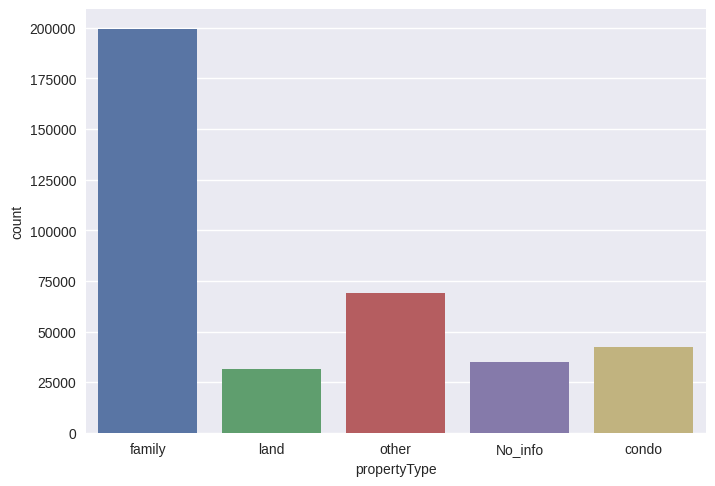

In [13]:
def new_property(propert):
    propert = str(propert)
    if propert == 'condo': return 'condo'
    elif propert == 'land': return 'land'
    elif 'family' in propert: return 'family'
    elif propert == 'nan': return 'No_info'
    elif 'lot/land' in propert: return 'land'
    else: 
        return 'other'
    
dpT['propertyType'] = dpT['propertyType'].apply(lambda x: new_property(x))

col = list(dpT['propertyType'].value_counts()[:5].keys())
sns.countplot(x=dpT['propertyType'], data=dpT)
plt.show()

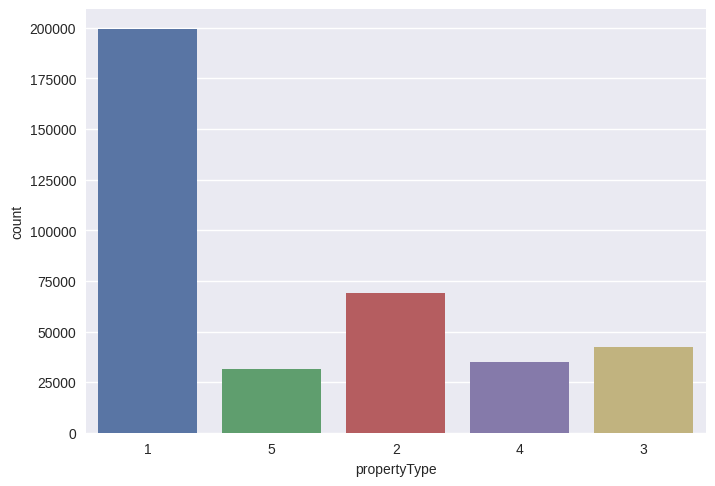

In [14]:
def new_property(propert):
    propert = str(propert)
    if propert == 'family': return '1'
    elif propert == 'other': return '2'
    elif propert == 'condo': return '3'
    elif propert == 'No_info': return '4'
    else: 
        return '5'
    
dpT['propertyType'] = dpT['propertyType'].apply(lambda x: new_property(x))

col = list(dpT['propertyType'].value_counts()[:5].keys())
sns.countplot(x=dpT['propertyType'], data=dpT)
plt.show()

### Преобразовываем столбец из объекта (object) в число (int)

In [15]:
dat = pd.to_numeric(dpT['propertyType'])

dpT['propertyType'] = dat.astype('int')
dpT['propertyType'].describe()

count    377185.000000
mean          2.019121
std           1.326744
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max           5.000000
Name: propertyType, dtype: float64

### ПРОМЕЖУТОЧНЫЙ ВЫВОД по типу жилья (propertyType): Основные характеристики показывают family(семья) .Это означает что основной фонд жилья данной базы жилые постройки ориентированные на семейные пары. По остальным показателям почти в равных долях земельные участки ,таунхаусы и кондо(совместные владения).
# Категория baths(количество ванных комнат)
### Сделаем предобработку и выведем топ 30 самых популярных значения baths

In [16]:
db = dpT.copy()

In [17]:
db['baths'] = db['baths'].apply(lambda x: str(x).lower())
print(db['baths'].value_counts().head(10))

print('Количество уникальных значений:',db['baths'].nunique())

nan             106338
2 baths          52471
3 baths          35508
2                20452
2.0              16576
4 baths          14764
3.0              10869
3                10113
bathrooms: 2      9538
2.5               8113
Name: baths, dtype: int64
Количество уникальных значений: 228


### Предобрабатываем категориалье признаки: уберем лишние значения, оставим только числовые¶

In [18]:
db['baths'] = db['baths'].apply(lambda x: str(x).replace('baths','').replace('bathrooms: ','').replace('ba','')
.replace('.0','').replace(',000','').replace('~','nan').replace('00','').replace(',','.').replace('1 / 1 / 1 / 1','4')
.replace('-- ','2').replace(' ','').replace('semimod','nan').replace('1-0 / 1-0 / 1', '3').replace('+','')
.replace('0/0','0').replace('sq.ft.','1').replace('1-0/1-0/1','3').replace('—','0').replace('116/116/116','3')
.replace('3-1/2-2','5').replace('2-1/2-1/1-1/1-1','6').replace('1/1-0/1-0/1-0','3').replace('1-2','2')
.replace('1/3-0','3').replace('nan','0')                             
)

In [19]:
dat = pd.to_numeric(db['baths'])
db['baths'] = dat.astype('float')

### Напишем функцию, которая покажет количество ванных комнат на графике

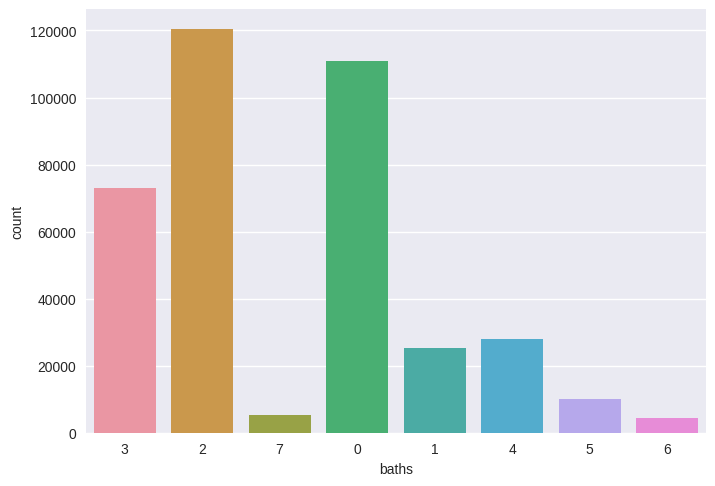

In [20]:
def db_quantile(x):
    if x <= 0:
        return '0'
    elif 0 < x <  2: 
        return '1'
    elif 2 <=  x <  3: 
        return '2'
    elif 3 <=  x <  4: 
        return '3'
    elif 4 <=  x <  5: 
        return '4'
    elif 5 <=  x <  6: 
        return '5'
    elif 6 <=  x <  7: 
        return '6'
    else:
        return '7'

db['baths'] = db['baths'].apply(lambda x: db_quantile(x))
sns.countplot(x=db['baths'], data=db)
plt.show()

### Преобразовываем столбец из объекта (object) в число  (int)

In [21]:
dat = pd.to_numeric(db['baths'])
db['baths'] = dat.astype('int')

### ПРОМЕЖУТОЧНЫЙ ВЫВОД по количеству ванных комнат (baths): Основные характеристики показывают ко-во ванн от 0(в него входят и информация по которой нет данных) до 4. Более 6 мы посчитали за выбросы и по графику видно что основной роли они не играют.
# Категория city (город в котором находится недвижимость)

In [22]:
dc = db.copy()

### Oбрабатываем пропуски в категориальных признаках самым простым вариантом, замена на unknown

In [23]:
dc['city'] = dc['city'].fillna('unknown')

In [24]:
def category_city(arg):
    
    million_cities = ['New York','Los Angeles','Chicago','Houston','Phoenix','Philadelphia','San Antonio'
                      ,'San Diego','Dallas']
    large_city = ['San Jose','Austin','Jacksonville' ,'Fort Worth' ,'Columbus' ,'Indianapolis ','Charlotte',
'San Francisco','Seattle ','Denver ','Oklahoma City' ,'Nashville ','El Paso','Washington ','Boston ','Las Vegas',
'Portland','Detroit','Louisville','Memphis','Baltimore','Milwaukee','Albuquerque','Fresno','Tucson','Sacramento',
'Mesa','Kansas City','Atlanta','Omaha','Colorado Springs','Raleigh','Virginia Beach','Long Beach','Miami',
'Oakland','Minneapolis','Tulsa','Bakersfield','Wichita','Arlington','Aurora','Tampa','New Orleans','Cleveland',
'Anaheim','Honolulu','Henderson','Stockton','Lexington','Corpus Christi','Riverside','Santa','Orlando','Irvine',
                'Cincinnati ','Newark' ,'Saint Paul' ,'Pittsburgh']
    big_city = ['Greensboro','St. Louis','Lincoln','Plano','Anchorage', 'Durham','Jersey City', 'Chandler',
'Chula Vista','Buffalo', 'North Las Vegas', 'Gilbert', 'Madison','Reno', 'Toledo', 'Fort Wayne','Lubbock',
'St. Petersburg','Laredo','Irving','Chesapeake','Winston-Salem', 'Glendale','Scottsdale','Garland','Boise',
'Norfolk','Spokane','Fremont','Richmond','Santa Clarita', 'San Bernardino', 'Baton Rouge','Hialeah','Tacoma',
'Modesto', 'Port St. Lucie','Huntsville','Des Moines', 'Moreno Valley', 'Fontana','Frisco','Rochester','Yonkers',
'Fayetville','Worcester', 'Columbus','Cape Coral', 'McKinney', 'Little Rock','Oxnard','Amarillo','Augusta',
'Salt Lake City', 'Montgomery','Birmingham','Grand Rapids','Grand Prairie','Overland Park','Tallahassee',
'Huntington Beach', 'Souix Falls','Peoria','Knoxville','Glendale','Vancouver','Providence','Akron','Brownsville',
'Mobile','Newport News','Tempe','Shreveport', 'Chattanooga','Fort Lauderdale','Aurora','Elk Grove','Ontario',
'Salem','Cary', 'Santa Rosa', 'Rancho Cucamonga','Eugene','Oceanside', 'Clarcksville','Garden Grove','Lancaster',
'Springfield','Pembroke Pines','Fort Collins','Palmdale','Salinas','Hayward', 'Corona','Paterson', 'Murfreesboro',
'Macon','Lakewood','Kelleen','Sprinfield','Alexandria','Kansas City','Sunnyvale','Hollywood','Roseville',
'Charleston','Escondido', 'Joliet','Jackson','Bellevue','Surprise','Naperville','Pasadena','Pomona','Bridgeport',
'Denton','Rockford', 'Mesquite','Savannah', 'Syracuse','McAllen','Torrance','Olathe','Visalia','Thornton',
'Fullerton','Gainesville','Waco','West Valley','Warren','Lakewood','Hampton','Dayton','Columbia','Orange',
'Cedar Rapids','Stamford','Victorville','Pasadena','Elizabeth','New Haven','Miramar','Kent','Sterling Heights',
'Carrollton','Coral Springs','Midland','Norman','Athens','Santa Clara','Columbia','Fargo','Pearland','Simi Valley',
'Meridian','Topeka','Allentown','Thousand-Oaks','Abilene','Vallejo','Concord','Round Rock','Arvada','Clovis',
'Palm Bay','Independence','Lafayette','Ann Arbor','Rochester','Hartford','College Station','Fairfield',
'Wilmington','North Charlestone','Billings','West Palm','Berkeley','Cambridge','Clearwater','West Jordan',
'Evansville','Richardson','Broken Arrow','Richmond','League City','Manchester','Lakeland','Carlsbad','Antioch',
'Westminster','High Point','Provo','Lowell','Elgin','Waterbury','Springfield','Gresham','Murrieta','Lewisville',
'Las Cruces','Lansing','Beaumont','Odessa','Pueblo','Peoria','Downey','Pompano Beach','Miami Gardens','Temecula',
'Everett','Costa Mesa','Ventura','Sparks','Santa Maria','Sugar Land','Greeley','South Bend','Dearborn','Concord',
'Edison','Tyler','Sandy Springs','West Covina','Green Bay','Centennial','Jurupa Valley','El Monte','Allen',
'Hillsboro','Menifee','Nampa','Spokane Valley','Rio Rancho','Brockton','El Cajon','Burbank','Inglewood','Renton',
'Davie','Rialto','Boulder','South Bend','Woodbridge','Vacaville','Whichita Falls','Edinburg','Chico','San Mateo',
'Bend','Goodyear','Buckeye','Daly City','Fishers','Quincy','Davenport','Hesperia','New Bedford','Lynn','Carmel',
'Longmont','Tuscaloosa','NorwalkGreensboro']
    
    city = arg.split(' , ')[0]
    if city in million_cities:
        return 'million_cities'
    elif city in large_city:
        return 'large_city'
    elif city in big_city:
        return 'big_city'
    else:
        return 'other'
    
#Создаём новые признаки с помощью функций-преобразователей  
dc['size_city'] = dc['city'].apply(category_city)
dc.head()

,propertyType,baths,city,sqft,zipcode,beds,state,target,size_city
0,1,3,Southern Pines,2900,28387,4,NC,"$418,000",other
1,1,3,Spokane Valley,"1,947 sqft",99216,3 Beds,WA,"$310,000",big_city
2,1,2,Los Angeles,"3,000 sqft",90049,3 Beds,CA,"$2,895,000",million_cities
3,1,7,Dallas,"6,457 sqft",75205,5 Beds,TX,"$2,395,000",million_cities
4,5,0,Palm Bay,NaN,32908,NaN,FL,"$5,000",big_city


In [25]:
dc = dc.drop(['city'], axis=1)

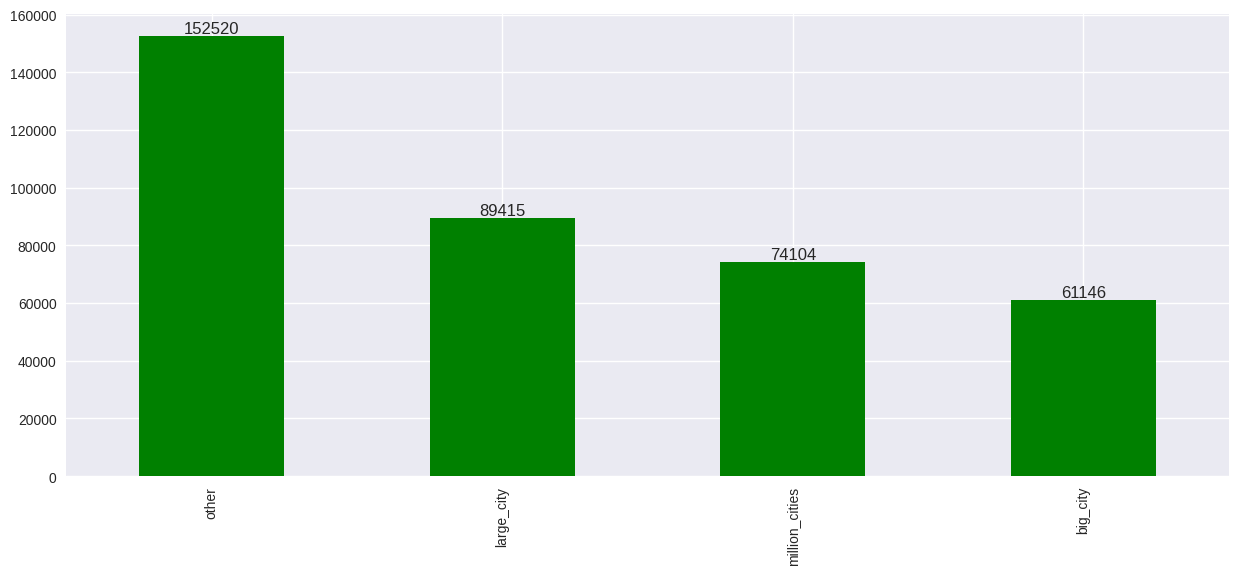

In [26]:
def show_plot(col):
    plt.figure(figsize=(15,6))
    col.value_counts().plot(kind='bar', color='green')
    for i,val in enumerate(col.value_counts()):
        plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'size':12})
    plt.show()
show_plot(dc['size_city'])

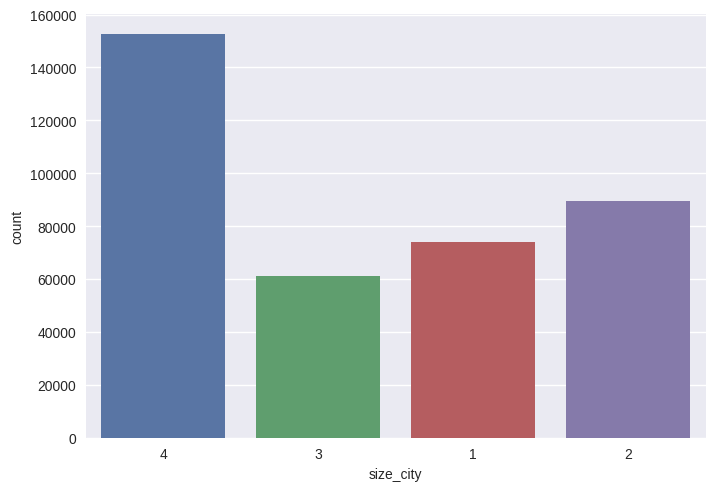

In [27]:
def new_property(propert):
    propert = str(propert)
    if propert == 'million_cities': return '1'
    elif propert == 'large_city': return '2'
    elif propert == 'big_city': return '3'
    else: 
        return '4'
    
dc['size_city'] = dc['size_city'].apply(lambda x: new_property(x))

col = list(dc['size_city'].value_counts()[:5].keys())
sns.countplot(x=dc['size_city'], data=dc)
plt.show()

### Преобразовываем столбец из объекта (object) в число (int)

In [28]:
dat = pd.to_numeric(dc['size_city'])

dc['size_city'] = dat.astype('int')
dc['size_city'].describe()

count    377185.000000
mean          2.774373
std           1.173193
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           4.000000
Name: size_city, dtype: float64

### ПРОМЕЖУТОЧНЫЙ ВЫВОД по городу в котором находится недвижимость (city): Мы разбили категорию на 4 фракции города миллионники(million_cities), крупные города(large_city)(от 300 тыс. чел. до 1 млн. чел.), большие города (big_city)(от 100 до 300 тыс. чел.) и другие. По графику видно нормальное распределение недвижимости по городам, большая часть недвижимости находится в городах с населением до 100 тыс человек 
# Категория sqft (размер недвижимости)

In [29]:
dsq = dc.copy()

In [30]:
dsq['sqft'] = dsq['sqft'].apply(lambda x: str(x).lower())
print(dsq['sqft'].value_counts().head(10))

print('Количество уникальных значений:',dsq['sqft'].nunique())

nan           40577
0             11854
1,200 sqft      839
1,000 sqft      654
1,100 sqft      573
1,800 sqft      563
1,500 sqft      547
--              535
2,000 sqft      523
1,400 sqft      517
Name: sqft, dtype: int64
Количество уникальных значений: 25406


In [31]:
dsq['sqft'] = dsq['sqft'].apply(lambda x:str(x)
.replace('Total interior livable area: ','').replace(' sqft ','').replace('sqft','').replace(' ','')
.replace('--','0').replace(',','.').replace('-','').replace('nan','0').replace('totalinteriorlivablearea:','') 
.replace('1.043.741','1.044').replace('2.585.006','2.585').replace('4.356.000','4.356').replace('795.979.430','796')
.replace('7.078.574','7.079').replace('1.598.652','1.599').replace('5.728.968','5.729').replace('1.524.600','1.525')
.replace('1.916.640','1.917').replace('1.239.282','1.239').replace('1.250.172','1.250').replace('1.761.113','1.761')                               
.replace('2.807.917','2.808').replace('.000','').replace('1.611.720','1.612').replace('1.417.442','1.417')
.replace('2.613.600','2.613'))
dsq['sqft'].value_counts().head(10)

0        53251
1.200     1298
1         1032
1.500      911
1.100      879
1.800      865
1.400      801
2          779
800        755
1.600      739
Name: sqft, dtype: int64

### Преобразовываем столбец из объекта (object) в число с плавающей запятой (float)
### Если errors='ignore', то значения игнорируются, но остаются

In [32]:
dat = pd.to_numeric(dsq['sqft'], errors='ignore')

dsq['sqft'] = dat.astype('float')
dsq['sqft'].describe()

count    3.771850e+05
mean     1.505767e+03
std      7.434666e+05
min      0.000000e+00
25%      1.300000e+00
50%      2.064000e+00
75%      4.005000e+00
max      4.566025e+08
Name: sqft, dtype: float64

<Axes: xlabel='sqft', ylabel='count'>

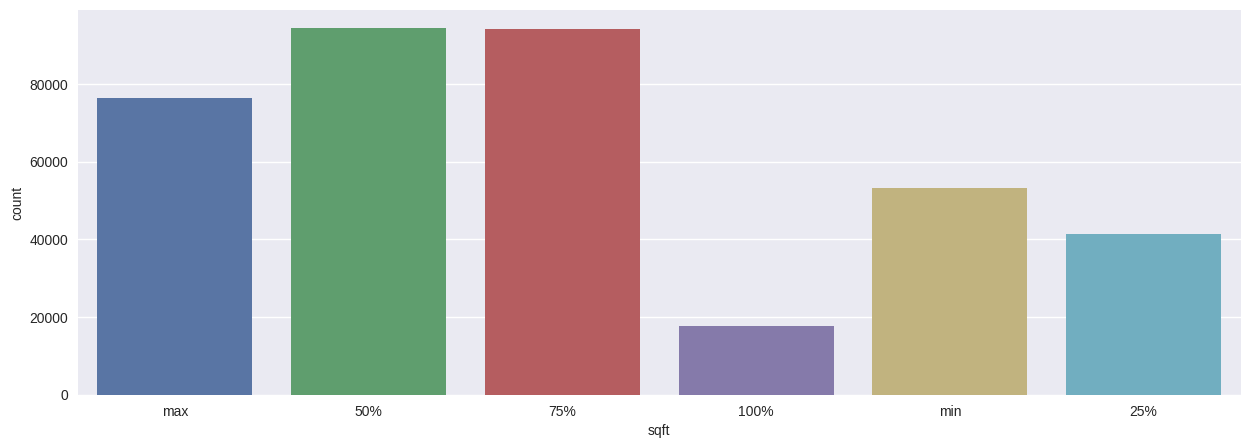

In [33]:
def dsq_sqft(x):
    if x < 1:
        return 'min'
    elif 1 <= x <= 1.302: 
        return '25%'
    elif 1.302 < x <= 2.069: 
        return '50%'
    elif 2.069 < x <=  4.02: 
        return '75%'
    elif 4.02 < x <= 7: 
        return '100%'
    else:
        return 'max'
    
plt.figure(figsize=(15,5))
col = dsq['sqft'].apply(lambda x: dsq_sqft(x))
sns.countplot(x=col, data=dsq)

### Удалим аномальные значения количества ванных комнат

In [34]:
dsq = dsq[(dsq['sqft'] >= 0) & (dsq['sqft'] <= 10)]
dsq['sqft'].value_counts()

0.000    53251
1.200     1298
1.000     1032
1.500      911
1.100      879
         ...  
5.977        1
5.514        1
6.884        1
9.016        1
6.958        1
Name: sqft, Length: 6970, dtype: int64

### ПРОМЕЖУТОЧНЫЙ ВЫВОД по категории размер недвижимости (sqft): Мы заменили пропуски и nan на 0,провели предобработку и перевод в числовой формат. Из графика видно что много данных по площади отсутствует,большая часть недвижимости имеет площать 1.300-4.000 квадратных фута.
# Категория zipcode (почтовый адрес)
### Почтовый адрес не является уникальным для каждой строки, кроме того для перевода в категорию он не подходит. В связи с нецелесообразностью данной категории удаляем ее.

In [35]:
dsq['zipcode'].value_counts().head(5)

32137    1576
78245    1379
78253    1274
78254    1229
33131     977
Name: zipcode, dtype: int64

In [36]:
dsq = dsq.drop(['zipcode'], axis=1)
dsq.head()

,propertyType,baths,sqft,beds,state,target,size_city
1,1,3,1.947,3 Beds,WA,"$310,000",3
2,1,2,3.000,3 Beds,CA,"$2,895,000",1
3,1,7,6.457,5 Beds,TX,"$2,395,000",1
4,5,0,0.000,NaN,FL,"$5,000",3
6,2,0,1.507,NaN,FL,"181,500",4


# Категория beds (количество кроватей)

In [37]:
dbed = dsq.copy()

In [38]:
dbed['beds'] = dbed['beds'].apply(lambda x: str(x).lower())
print(dbed['beds'].value_counts().head(5))

print('Количество уникальных значений:',dbed['beds'].nunique())

nan       77578
3 beds    51129
4 beds    35141
3         22042
2 beds    19484
Name: beds, dtype: int64
Количество уникальных значений: 1140


In [39]:
dbed['beds'] = dbed['beds'].apply(lambda x: str(x).replace('nan','0').replace('beds','').replace('bd','')
.replace('baths','1').replace('.0','').replace('--','0').replace('bath','1')                            
.replace('sqft','').replace(',000','').replace('acre','').replace('s','').replace(',','.')
.replace('101.020bedroom.0living0room.0range/oven.0refrigerator','1').replace('10120bedroom','1')
.replace('101.020bedroom','1')
)

dbed['beds'].value_counts().head(10)

0     78446
3     63538
4     43378
2     23308
3     22822
4     15538
1     15070
5     13841
2      9182
5      4879
Name: beds, dtype: int64

<Axes: xlabel='beds', ylabel='count'>

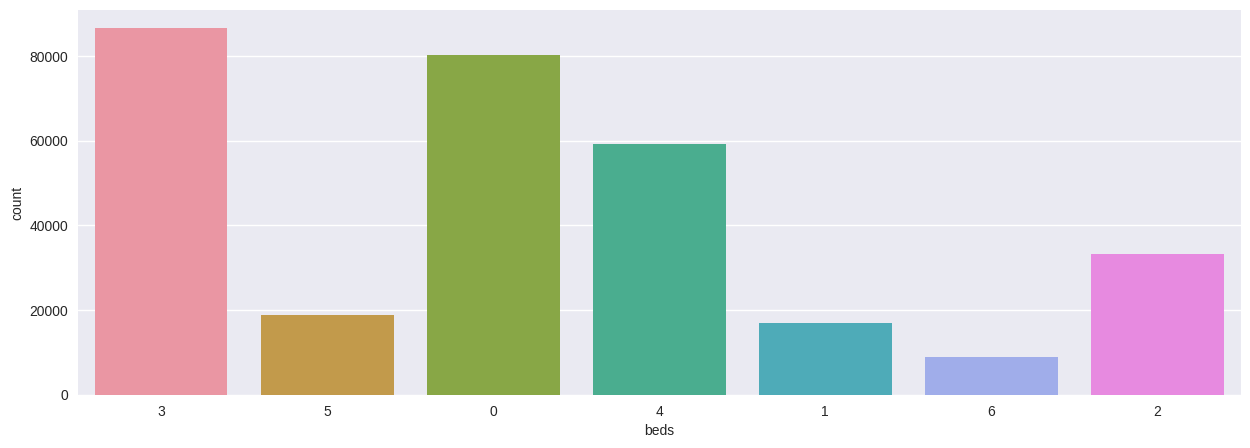

In [40]:
dbed['beds'] = dbed['beds'].apply(lambda x: '1' if '1' in x else '2' if '2' in x else '0' if '0' in x else '3' if '3' in x 
                                  else '4' if '4' in x else '5' if '5' in x else '6')
plt.figure(figsize=(15,5))
sns.countplot(x=dbed['beds'], data=dbed)

### Преобразовываем столбец из объекта (object) в число (int)

In [41]:
dbed['beds'] = dbed['beds'].astype('int')
dbed['beds'].describe()

count    303514.000000
mean          2.392094
std           1.744939
min           0.000000
25%           0.000000
50%           3.000000
75%           4.000000
max           6.000000
Name: beds, dtype: float64

### ПРОМЕЖУТОЧНЫЙ ВЫВОД по категории количество кроватей (beds): Мы заменили пропуски и nan на 0,провели предобработку и перевод в числовой формат. Из графика видно что много данных по beds отсутствует,большая часть beds недвижимости имеет 3 кровати.
# Категория state (штат США в котором находится недвижимость)

In [42]:
dst = dbed.copy()

In [43]:
print(dst['state'].value_counts().head(10))

print('Количество уникальных значений:',dst['state'].nunique())

FL    94449
TX    75330
NY    19452
NC    17952
CA    17729
TN    13653
OH     8677
WA     8627
NV     7660
IL     7399
Name: state, dtype: int64
Количество уникальных значений: 39


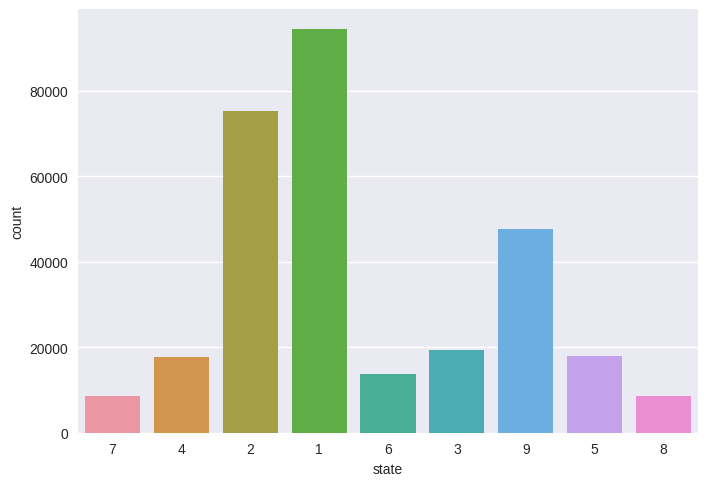

In [44]:
def new_property(propert):
    propert = str(propert)
    if propert == 'FL': return '1'
    elif propert == 'TX': return '2'
    elif propert == 'NY': return '3'
    elif propert == 'CA': return '4'
    elif propert == 'NC': return '5'
    elif propert == 'TN': return '6'
    elif propert == 'WA': return '7'
    elif propert == 'OH': return '8'
    else: 
        return '9'
    
dst['state'] = dst['state'].apply(lambda x: new_property(x))

col = list(dst['state'].value_counts()[:5].keys())
sns.countplot(x=dst['state'], data=dst)
plt.show()

### Преобразовываем столбец из объекта (object) в число (int)

In [45]:
dat = pd.to_numeric(dst['state'])

dst['state'] = dat.astype('int')
dst['state'].describe()

count    303514.000000
mean          3.639598
std           2.933329
min           1.000000
25%           1.000000
50%           2.000000
75%           6.000000
max           9.000000
Name: state, dtype: float64

### ПРОМЕЖУТОЧНЫЙ ВЫВОД по категории штат США в котором находится недвижимость (state): Дополнительная предобработка не нужна,пропусков нет. Судя по графику в наших данных в основном представлены 2 штата Флорида и Техас
# Категория target (целевой признак)

In [46]:
df = dst.copy()

In [47]:
print(df['target'].value_counts().head(10))

print('Количество уникальных значений:',df['target'].nunique())

$225,000    1074
$275,000    1013
$350,000    1009
$250,000    1005
$299,900     995
$325,000     950
$399,000     934
$249,900     930
$375,000     892
$450,000     890
Name: target, dtype: int64
Количество уникальных значений: 39725


In [48]:
df['target'] = df['target'].apply(lambda x: str(x).replace('$','').replace(' - ','').replace('-','')
.replace('+','').replace('/mo','000').replace('nan','225').replace(',000', '').replace(',900', '')
.replace(',600', '').replace(',300', '').replace(',500', '').replace(',200', '').replace(',800', '')
.replace(',990', '').replace(',999', '').replace(',700', '').replace(',400', '').replace(',100', '')
.replace(',950', '').replace(',850', '').replace(',150', '').replace(',888', '').replace(',995', '')
.replace('3,950000', '4').replace('2,490000', '2'))
df['target'] = df['target'].apply(lambda x: x.replace('27603-4374', '23229'))

In [49]:
import re

def make_target(x):
    x = re.sub('[^0-9]', '', x)
    x = int(x)
    return x

df['target'] = df['target'].apply(make_target)
df['target'].describe()

count    3.035140e+05
mean     3.412874e+04
std      2.136919e+05
min      1.000000e+00
25%      1.860000e+02
50%      3.390000e+02
75%      6.890000e+02
max      3.938101e+07
Name: target, dtype: float64

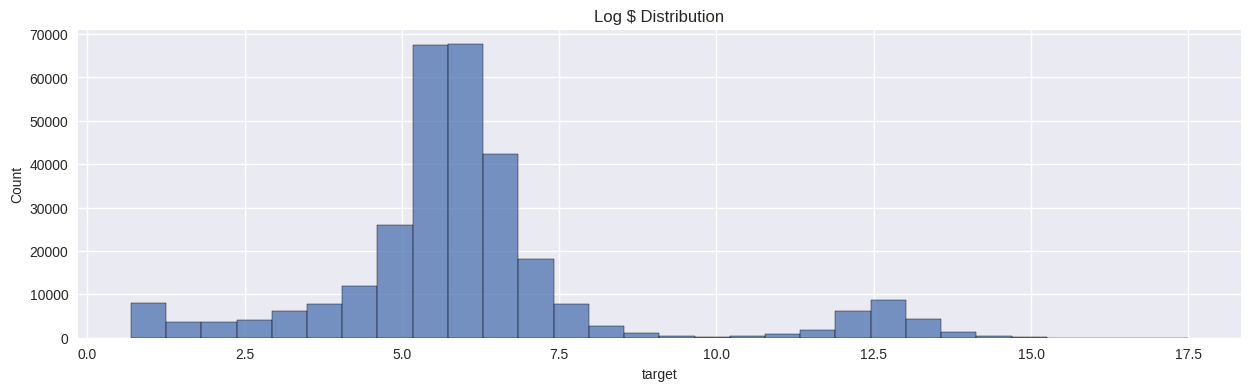

In [50]:
axes = plt.subplots(figsize=(15, 4))
#гистограмма в логарифмическом масштабе
log_target= np.log(df['target'] + 1)
histplot = sns.histplot(log_target , bins=30, ax=axes[1])
histplot.set_title('Log $ Distribution');

In [51]:
# Численный показатель асимметрии можно вычислить с помощью метода:skew():
print(log_target.skew())

1.193454849549842


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303514 entries, 1 to 377184
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   propertyType  303514 non-null  int64  
 1   baths         303514 non-null  int64  
 2   sqft          303514 non-null  float64
 3   beds          303514 non-null  int64  
 4   state         303514 non-null  int64  
 5   target        303514 non-null  int64  
 6   size_city     303514 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 18.5 MB


### ПРОМЕЖУТОЧНЫЙ ВЫВОД: Мы провели разведывательный анализ данных,отборали и удалили неинформативные признаки,подобрали информацию с различных источников данных для последующего анализа,подготовили данные передавать на вход обучения модели и проверили гипотезы отбора признаков и их преобразование.

# МАШИННОЕ ОБУЧЕНИЕ
### Мы знаем, что модель линейной регрессии не умеет работать с категориальными признаками, поэтому перевели все категории в числовой формат для удобства дальнейшей работы

### Логарифмируем числовые признаки, чтобы придать им форму нормального распределения

In [53]:
df['propertyType'] = np.log(df['propertyType']+1)
df['baths'] = np.log(df['baths']+1)
df['sqft'] = np.log(df['sqft']+1)
df['beds'] = np.log(df['beds']+1)
df['state'] = np.log(df['state']+1)
df['target'] = np.log(df['target']+1)
df['size_city'] = np.log(df['size_city']+1)

### Создаем новый признак - цена недвижтмости

In [54]:
df['price'] = abs((df['sqft'] * df['target']))

In [55]:
df.head()

,propertyType,baths,sqft,beds,state,target,size_city,price
1,0.693147,1.386294,1.080788,1.386294,2.079442,5.739793,1.386294,6.203498
2,0.693147,1.098612,1.386294,1.386294,1.609438,7.971086,0.693147,11.050271
3,0.693147,2.079442,2.009153,1.791759,1.098612,7.781556,0.693147,15.634338
4,1.791759,0.000000,0.000000,0.000000,0.693147,1.791759,1.386294,0.000000
6,1.098612,0.000000,0.919087,0.000000,0.693147,5.204007,1.609438,4.782934


### Оцениваем мультиколинеарность и взаимосвязь с целевым признаком. Строим тепловую карту корреляций

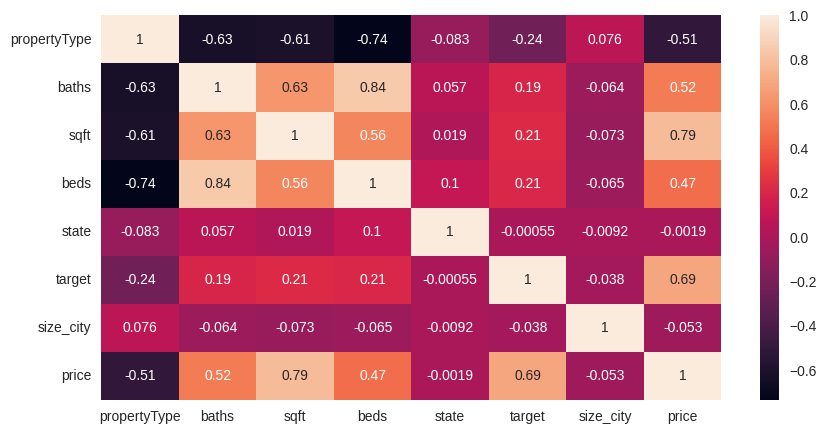

In [56]:
plt.figure(figsize = (10, 5))
sns.heatmap(df.corr(), annot = True);

In [57]:
def outliers_iqr_mod(data, feature, left=1.5, right=1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x> upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

# Применим эту функцию к таблице df и признаку target, а также выведем размерности результатов:
outliers, cleaned = outliers_iqr_mod(df, 'target')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 49488
Результирующее число записей: 254026


### Согласно классическому методу Тьюки, под выбросы у нас попали 49488 записи в таблице. Давайте построим гистограмму и коробчатую диаграмму на новых данных df:

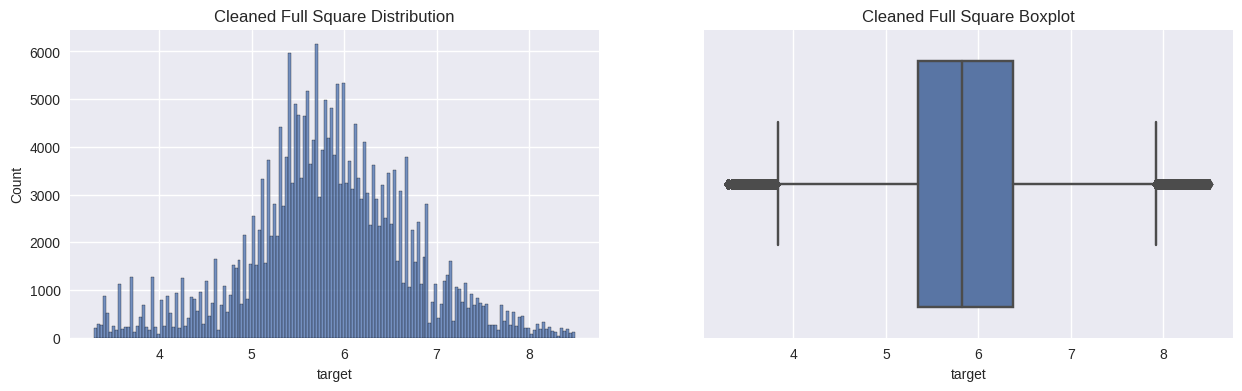

In [58]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='target', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='target', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

### это уже больше похоже на реальный рынок недвижимости: основная стоимость квартир в интервале от  150 до 500 $ за кв. м, а далее частота наблюдений постепенно падает.
### Создаем матрицу наблюдений  𝑋 и вектор ответов  𝑦

In [59]:
X = df.drop('target', axis=1)
y = df['target']

### Разделяем выборку на тренировочную и тестовую в соотношении 80/20. 
### Выводим размеры полученных выборок

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (242811, 7)
Test shape: (60703, 7)


### Производим нормализацию данных с помощью min-max нормализации

In [61]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Моделирование + оценка модели
### Линейная регрессия

In [62]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Test MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))
    
def rmse(y_true, y_pred):
    return np.sqrt(((y_true - y_pred) ** 2).mean())    

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Cоздаем логарифмированный целевой признак цены, инициализируем объект класса линейная регрессия, обучаем модель предсказывать логарифм целевого признака, делаем предсказание для каждой из выборок. Т.к. мы обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту, после чего выводим результирующие метрики

In [63]:
y_train_log = np.log(y_train)

lr = linear_model.LinearRegression()
lr.fit(X_train, y_train_log)

y_train_pred = np.exp(lr.predict(X_train))
y_test_pred = np.exp(lr.predict(X_test))

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.214
Train MAE: 0.963
Train MAPE: 21.242


Test R^2: 0.149
Test MAE: 0.974
Test MAPE: 21.268


### Инициализируем объект класса линейная регрессия, oбучаем модель - ищем параметры, делаем предсказание для каждой из выборок и выводим результирующие метрики

In [64]:
sgd_lr = linear_model.SGDRegressor(random_state=42)
sgd_lr.fit(X_train_scaled, y_train)

y_train_pred = sgd_lr.predict(X_train_scaled)
y_test_pred = sgd_lr.predict(X_test_scaled)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.767
Train MAE: 0.653
Train MAPE: 18.592


Test R^2: 0.768
Test MAE: 0.655
Test MAPE: 18.505


### Создаем объект для генерации полиномиальных признаков степени 2, вычисляем параметры генерации - результирующее количество признак и производим преобразование для каждой из выборок

In [65]:
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)

poly.fit(X_train_scaled)

X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (242811, 35)
Test shape: (60703, 35)


### Теперь инициализируем объект класса линейная регрессия с L2-регуляризацией, обучаем модель предсказывать логарифм целевого признака, делаем предсказание для каждой из выборок, т.к. обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту, после чего выводим результирующие метрики

In [66]:
ridge_lr_poly = linear_model.Ridge()

ridge_lr_poly.fit(X_train_scaled_poly, y_train_log)

y_train_pred = np.exp(ridge_lr_poly.predict(X_train_scaled_poly))
y_test_pred = np.exp(ridge_lr_poly.predict(X_test_scaled_poly))

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.784
Train MAE: 0.573
Train MAPE: 13.773


Test R^2: 0.782
Test MAE: 0.578
Test MAPE: 13.743


### Создаем список из 20 возможных значений от 0.001 до 10, cоздаем пустые списки, в которые будем добавлять результаты, после чего создаем объект класса линейная регрессия с L2-регуляризацией, обучаем модель и делаем предсказание. Визуализируем изменение R^2 в зависимости от alpha

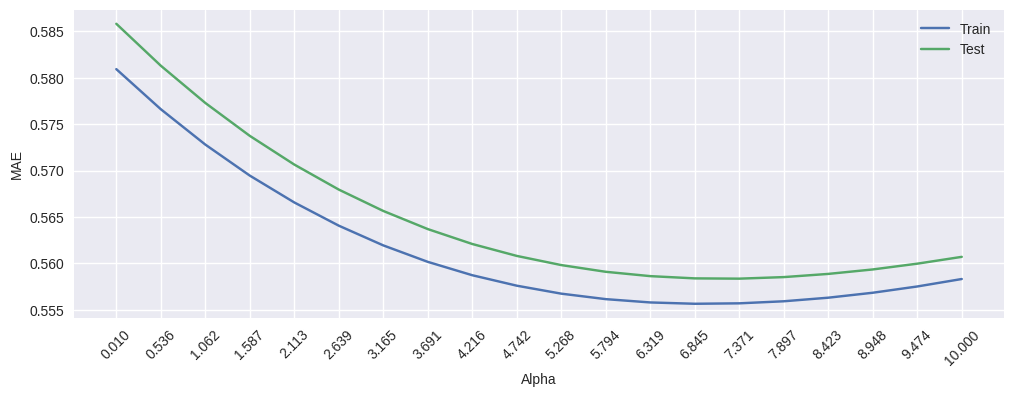

In [67]:
alpha_list = np.linspace(0.01, 10, 20)

train_scores = []
test_scores = []
for alpha in alpha_list:
    
    ridge_lr_poly = linear_model.Ridge(alpha=alpha, max_iter=10000)
    
    ridge_lr_poly.fit(X_train_scaled_poly, y_train_log)

    y_train_predict_poly = np.exp(ridge_lr_poly.predict(X_train_scaled_poly))
    y_test_predict_poly = np.exp(ridge_lr_poly.predict(X_test_scaled_poly))

    train_scores.append(metrics.mean_absolute_error(y_train, y_train_predict_poly))
    test_scores.append(metrics.mean_absolute_error(y_test, y_test_predict_poly))

fig, ax = plt.subplots(figsize=(12, 4)) 
ax.plot(alpha_list, train_scores, label='Train') 
ax.plot(alpha_list, test_scores, label='Test')
ax.set_xlabel('Alpha')
ax.set_ylabel('MAE')
ax.set_xticks(alpha_list)
ax.xaxis.set_tick_params(rotation=45) 
ax.legend(); 

### Создаем объект класса линейная регрессия с L2-регуляризацией, выставляем параметр alpha в подобранное выше значение, обучаем модель и делаем предсказание.

In [68]:
ridge_lr = linear_model.Ridge(alpha=0.01)

ridge_lr.fit(X_train_scaled_poly, y_train_log)

y_train_pred = np.exp(ridge_lr.predict(X_train_scaled_poly))
y_test_pred = np.exp(ridge_lr.predict(X_test_scaled_poly))

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.781
Train MAE: 0.581
Train MAPE: 13.811


Test R^2: 0.778
Test MAE: 0.586
Test MAPE: 13.784


### Визуализируем ошибки модели на тренировочной и тестовой выборке. Для удобства визуализации составим DataFrame из ошибок. Строим boxplot для ошибок

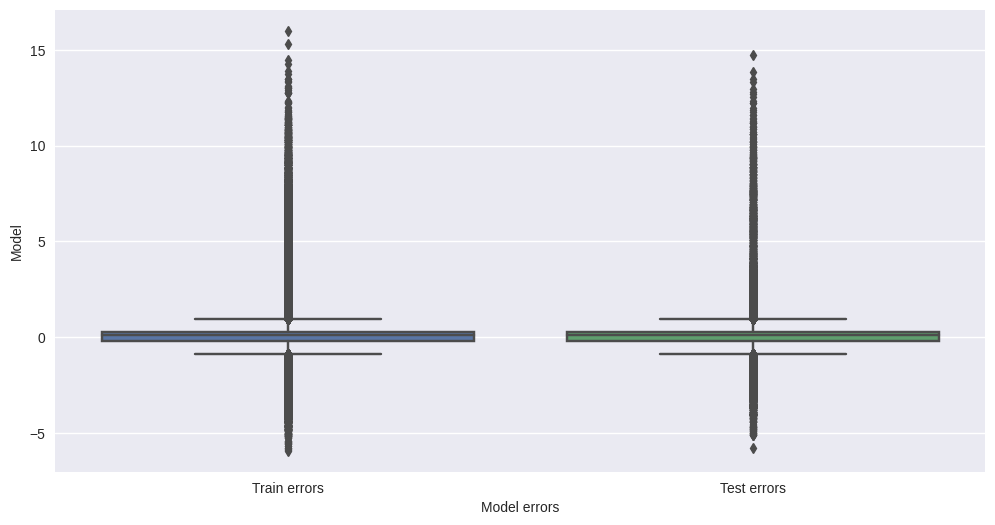

In [69]:
fig, ax = plt.subplots(figsize=(12, 6))

y_train_errors = y_train - y_train_pred
y_test_errors = y_test - y_test_pred

predict_df = pd.DataFrame(
    {'Train errors': y_train_errors, 
     'Test errors': y_test_errors
    }
)

sns.boxplot(data=predict_df, ax=ax)
ax.set_xlabel('Model errors')
ax.set_ylabel('Model');

### Создаем объект класса градиент бустинг регрессия, обучаем модель и делаем предсказание

In [70]:
gb = GradientBoostingRegressor(max_depth=15, min_samples_leaf=15,  min_samples_split=10, max_features='auto',
                               random_state=42
)
gb.fit(X_train, np.log(y_train))

y_train_pred = gb.predict(X_train)
y_train_pred = np.exp(y_train_pred)

y_test_pred = gb.predict(X_test)
y_test_pred = np.exp(y_test_pred)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

/home/home/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/home/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/home/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/home/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  war

/home/home/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/home/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/home/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/home/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  war

/home/home/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/home/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/home/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/home/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  war

/home/home/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


Train R^2: 0.864
Train MAE: 0.263
Train MAPE: 7.879


Test R^2: 0.859
Test MAE: 0.273
Test MAPE: 8.097


### Функция, которая выводит веса признаков для модели

In [71]:
def show_weights(features, weights, scales):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=2)
    sorted_weights = sorted(zip(weights, features, scales), reverse=True)
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    scales = [x[2] for x in sorted_weights]
    sns.barplot(y=features, x=weights, ax=axs[0], orient='h')
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=scales, ax=axs[1], orient='h')
    axs[1].set_xlabel("Scale")
    plt.tight_layout()

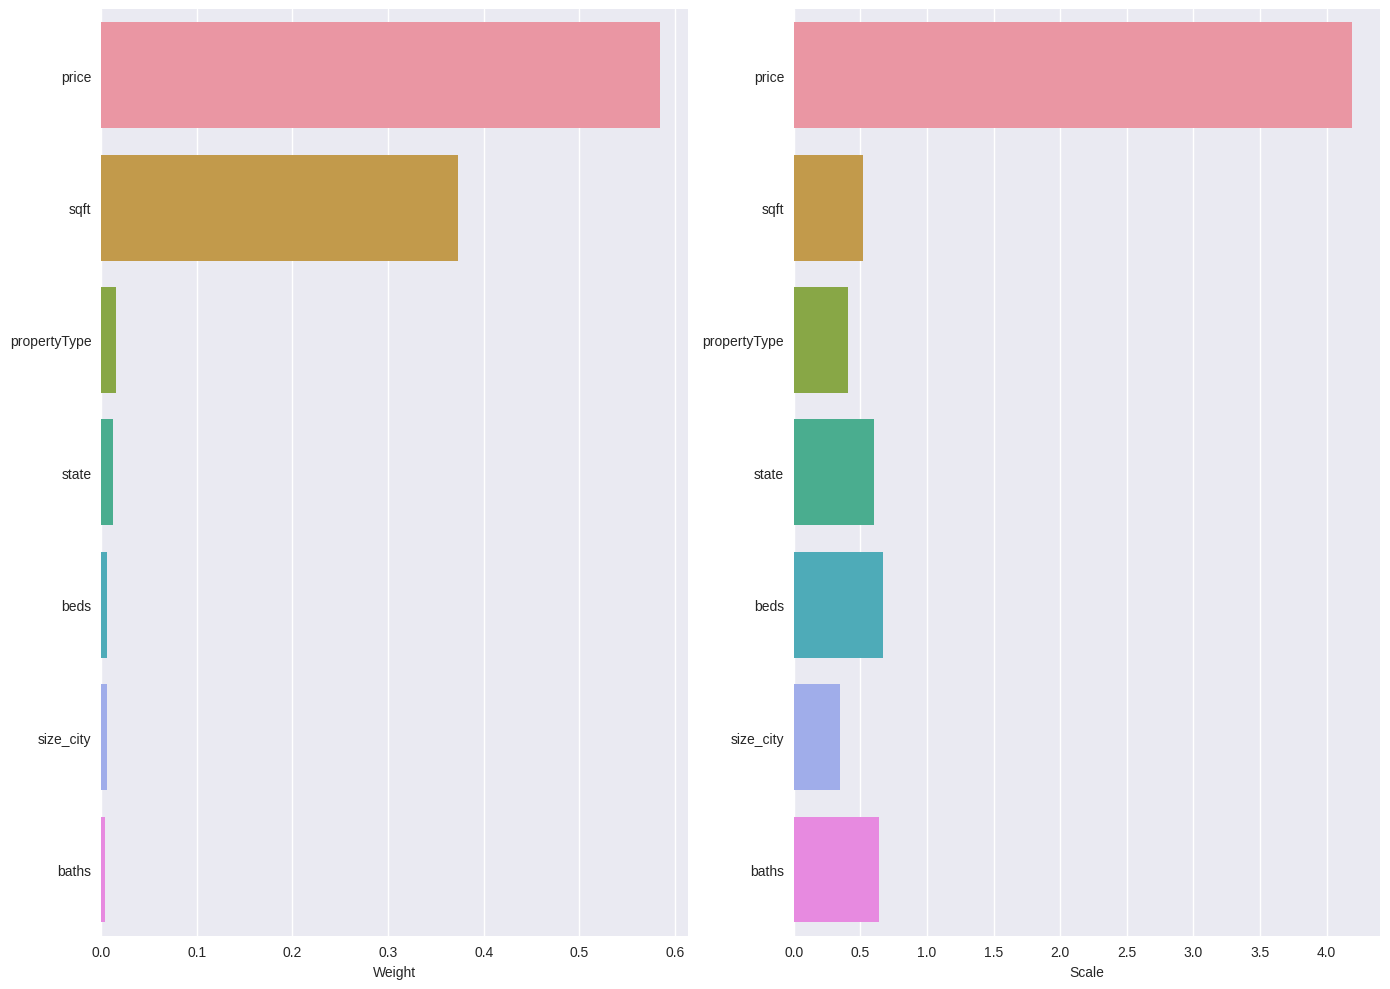

In [72]:
show_weights(X.columns, gb.feature_importances_, X_train.std())

### Создаем объект класса случайный лес регрессия, обучаем модель и делаем предсказание

In [73]:
rf = RandomForestRegressor(max_depth=110, min_samples_split=10, min_samples_leaf = 5, max_features='auto',
                           bootstrap=True, oob_score=True, n_jobs=-1, random_state=42
)
rf.fit(X_train, np.log(y_train))

y_train_pred = rf.predict(X_train)
y_train_pred = np.exp(y_train_pred)

y_test_pred = rf.predict(X_test)
y_test_pred = np.exp(y_test_pred)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

/home/home/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Train R^2: 0.863
Train MAE: 0.265
Train MAPE: 7.931


Test R^2: 0.860
Test MAE: 0.272
Test MAPE: 8.054


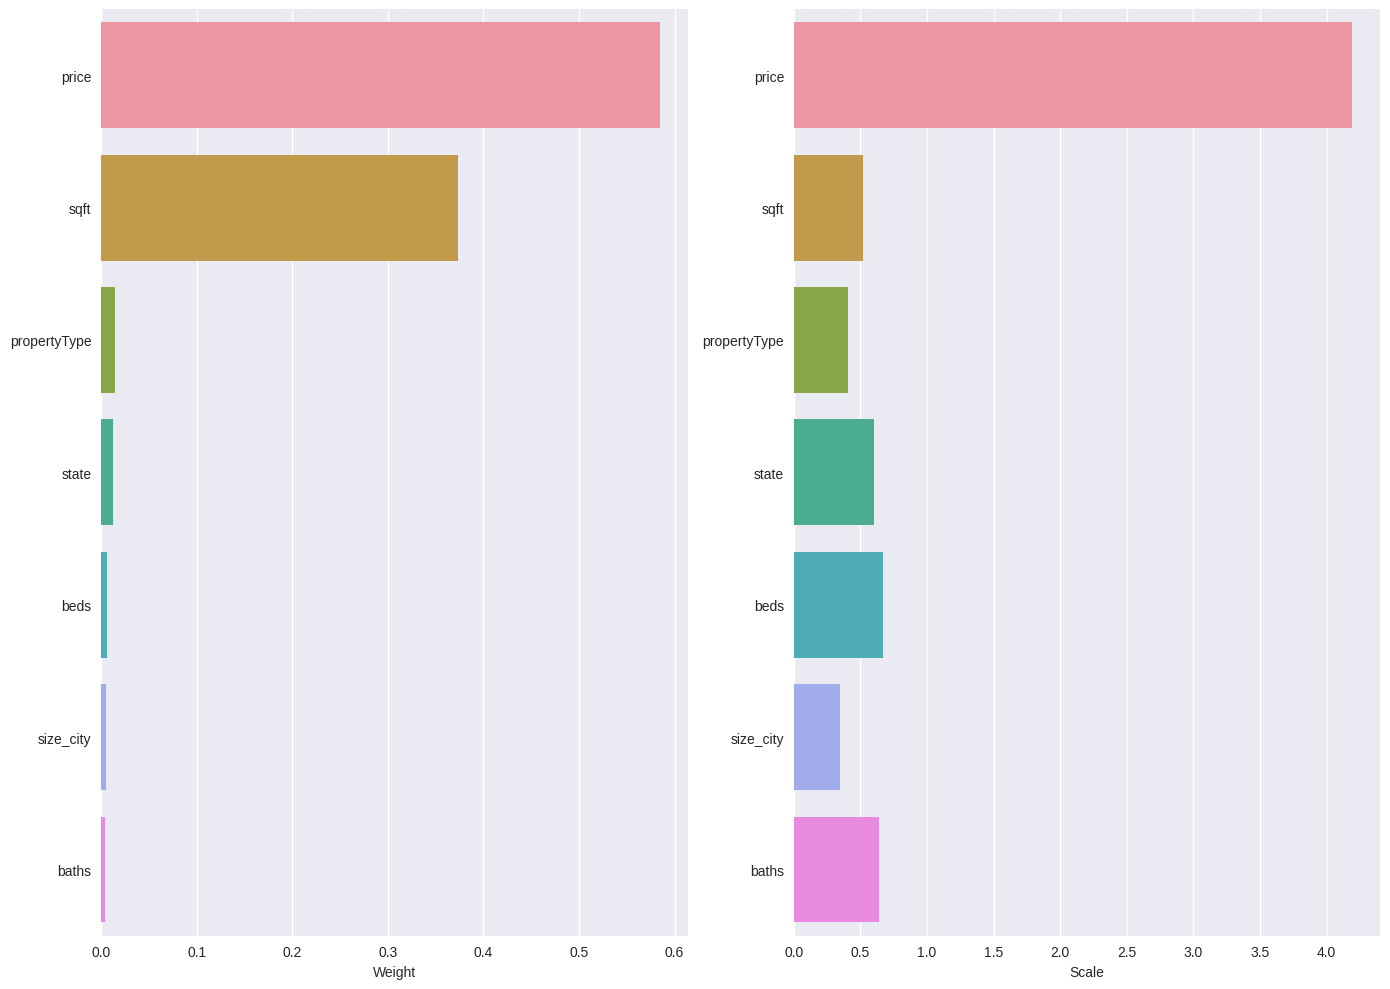

In [74]:
show_weights(X.columns, rf.feature_importances_, X_train.std())

### Создаем объект класса кэтбуст регрессия, обучаем модель и делаем предсказание

In [75]:
ctb = CatBoostRegressor(iterations = 5000,
                        random_seed = 42,
                        eval_metric='MAPE',
                        custom_metric=['R2', 'MAE'],
                        silent=True,
)
ctb.fit(X_train, np.log(y_train),
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
)

y_train_pred = rf.predict(X_train)
y_train_pred = np.exp(y_train_pred)

y_test_pred = rf.predict(X_test)
y_test_pred = np.exp(y_test_pred)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.863
Train MAE: 0.265
Train MAPE: 7.931


Test R^2: 0.860
Test MAE: 0.272
Test MAPE: 8.054


## Модель на основе настроенного Градиентного бустинга

In [76]:
model = lgm.LGBMRegressor()

cv = KFold(n_splits=5, random_state=1, shuffle=True)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1,
                           error_score='raise'
)

print('MAE mean: %.3f, MAE std: %.3f' % (n_scores.mean(), n_scores.std()))

MAE mean: -0.311, MAE std: 0.002


## Модель на основе CatBoost

In [77]:
model = CatBoostRegressor()

cv = KFold(n_splits=5, random_state=1, shuffle=True)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1,
                           error_score='raise'
)

print('MAE std: %.3f, MAE std: %.3f' % (n_scores.mean(), n_scores.std()))

Learning rate set to 0.094133
0:	learn: 2.2257548	total: 118ms	remaining: 1m 58s
1:	learn: 2.0829663	total: 169ms	remaining: 1m 24s
2:	learn: 1.9550346	total: 187ms	remaining: 1m 2s
3:	learn: 1.8422104	total: 204ms	remaining: 50.8s
4:	learn: 1.7405415	total: 221ms	remaining: 44s
5:	learn: 1.6504854	total: 237ms	remaining: 39.2s
6:	learn: 1.5716704	total: 282ms	remaining: 40.1s
7:	learn: 1.5009899	total: 354ms	remaining: 43.9s
8:	learn: 1.4405872	total: 373ms	remaining: 41.1s
9:	learn: 1.3873047	total: 397ms	remaining: 39.3s
10:	learn: 1.3400237	total: 419ms	remaining: 37.7s
11:	learn: 1.3013776	total: 442ms	remaining: 36.4s
12:	learn: 1.2664976	total: 480ms	remaining: 36.4s
13:	learn: 1.2355831	total: 518ms	remaining: 36.5s
14:	learn: 1.2088123	total: 544ms	remaining: 35.7s
15:	learn: 1.1853707	total: 564ms	remaining: 34.7s
16:	learn: 1.1652822	total: 591ms	remaining: 34.1s
17:	learn: 1.1474294	total: 617ms	remaining: 33.6s
18:	learn: 1.1282031	total: 664ms	remaining: 34.3s
19:	learn: 

Learning rate set to 0.094133
0:	learn: 2.2257814	total: 81.5ms	remaining: 1m 21s
1:	learn: 2.0837873	total: 130ms	remaining: 1m 4s
2:	learn: 1.9577675	total: 148ms	remaining: 49s
3:	learn: 1.8419362	total: 191ms	remaining: 47.5s
4:	learn: 1.7384044	total: 238ms	remaining: 47.4s
5:	learn: 1.6485113	total: 266ms	remaining: 44.1s
6:	learn: 1.5684234	total: 308ms	remaining: 43.7s
7:	learn: 1.4977336	total: 346ms	remaining: 42.9s
8:	learn: 1.4376967	total: 436ms	remaining: 48s
9:	learn: 1.3866105	total: 458ms	remaining: 45.4s
10:	learn: 1.3389263	total: 544ms	remaining: 48.9s
11:	learn: 1.2984678	total: 676ms	remaining: 55.6s
12:	learn: 1.2633152	total: 741ms	remaining: 56.3s
13:	learn: 1.2328273	total: 784ms	remaining: 55.2s
14:	learn: 1.2055976	total: 839ms	remaining: 55.1s
15:	learn: 1.1820632	total: 933ms	remaining: 57.4s
16:	learn: 1.1617057	total: 1.02s	remaining: 59s
17:	learn: 1.1425054	total: 1.1s	remaining: 1m
18:	learn: 1.1265222	total: 1.27s	remaining: 1m 5s
19:	learn: 1.112139

Learning rate set to 0.094133
0:	learn: 2.2219720	total: 107ms	remaining: 1m 46s
1:	learn: 2.0782040	total: 208ms	remaining: 1m 43s
2:	learn: 1.9507201	total: 277ms	remaining: 1m 31s
3:	learn: 1.8360132	total: 386ms	remaining: 1m 36s
4:	learn: 1.7321753	total: 468ms	remaining: 1m 33s
5:	learn: 1.6411217	total: 541ms	remaining: 1m 29s
6:	learn: 1.5607626	total: 635ms	remaining: 1m 30s
7:	learn: 1.4928020	total: 785ms	remaining: 1m 37s
8:	learn: 1.4305457	total: 925ms	remaining: 1m 41s
9:	learn: 1.3765096	total: 1.05s	remaining: 1m 43s
10:	learn: 1.3300886	total: 1.2s	remaining: 1m 47s
11:	learn: 1.2901556	total: 1.34s	remaining: 1m 50s
12:	learn: 1.2552192	total: 1.44s	remaining: 1m 49s
13:	learn: 1.2237591	total: 1.52s	remaining: 1m 47s
14:	learn: 1.1973620	total: 1.67s	remaining: 1m 49s
15:	learn: 1.1734650	total: 1.75s	remaining: 1m 47s
16:	learn: 1.1540200	total: 1.82s	remaining: 1m 45s
17:	learn: 1.1361219	total: 1.94s	remaining: 1m 45s
18:	learn: 1.1207575	total: 2.08s	remaining: 

160:	learn: 0.8848798	total: 10.8s	remaining: 56.3s
161:	learn: 0.8847974	total: 10.8s	remaining: 56.1s
162:	learn: 0.8846140	total: 10.9s	remaining: 56.2s
163:	learn: 0.8844678	total: 11s	remaining: 56.2s
164:	learn: 0.8840030	total: 11.1s	remaining: 56s
165:	learn: 0.8838879	total: 11.2s	remaining: 56.2s
166:	learn: 0.8837974	total: 11.4s	remaining: 56.8s
167:	learn: 0.8836942	total: 11.4s	remaining: 56.6s
168:	learn: 0.8832892	total: 11.5s	remaining: 56.3s
169:	learn: 0.8830819	total: 11.5s	remaining: 56.1s
170:	learn: 0.8830020	total: 11.5s	remaining: 55.9s
171:	learn: 0.8829486	total: 11.6s	remaining: 55.6s
172:	learn: 0.8828229	total: 11.6s	remaining: 55.3s
173:	learn: 0.8826686	total: 11.7s	remaining: 55.4s
174:	learn: 0.8822862	total: 11.7s	remaining: 55.3s
175:	learn: 0.8821277	total: 11.8s	remaining: 55.3s
176:	learn: 0.8820811	total: 11.9s	remaining: 55.1s
177:	learn: 0.8819857	total: 11.9s	remaining: 55.1s
178:	learn: 0.8818990	total: 12s	remaining: 55.1s
179:	learn: 0.8815

156:	learn: 0.8853159	total: 13s	remaining: 1m 9s
157:	learn: 0.8852001	total: 13.1s	remaining: 1m 10s
158:	learn: 0.8851112	total: 13.3s	remaining: 1m 10s
159:	learn: 0.8849231	total: 13.4s	remaining: 1m 10s
160:	learn: 0.8848241	total: 13.5s	remaining: 1m 10s
161:	learn: 0.8847418	total: 13.6s	remaining: 1m 10s
162:	learn: 0.8845898	total: 13.7s	remaining: 1m 10s
163:	learn: 0.8844457	total: 13.8s	remaining: 1m 10s
164:	learn: 0.8843914	total: 14s	remaining: 1m 10s
165:	learn: 0.8842703	total: 14.1s	remaining: 1m 10s
166:	learn: 0.8840266	total: 14.1s	remaining: 1m 10s
167:	learn: 0.8839416	total: 14.1s	remaining: 1m 9s
168:	learn: 0.8838325	total: 14.2s	remaining: 1m 9s
169:	learn: 0.8833648	total: 14.3s	remaining: 1m 9s
170:	learn: 0.8832884	total: 14.4s	remaining: 1m 9s
171:	learn: 0.8828460	total: 14.5s	remaining: 1m 9s
172:	learn: 0.8827392	total: 14.6s	remaining: 1m 9s
173:	learn: 0.8826294	total: 14.7s	remaining: 1m 9s
174:	learn: 0.8825604	total: 14.8s	remaining: 1m 9s
175:	l

318:	learn: 0.8728700	total: 23.7s	remaining: 50.6s
319:	learn: 0.8727991	total: 23.8s	remaining: 50.7s
320:	learn: 0.8727738	total: 23.9s	remaining: 50.6s
321:	learn: 0.8726501	total: 24s	remaining: 50.6s
322:	learn: 0.8726251	total: 24.2s	remaining: 50.6s
323:	learn: 0.8726083	total: 24.3s	remaining: 50.7s
324:	learn: 0.8725826	total: 24.4s	remaining: 50.7s
325:	learn: 0.8725521	total: 24.6s	remaining: 50.8s
326:	learn: 0.8725082	total: 24.7s	remaining: 50.8s
327:	learn: 0.8724816	total: 24.7s	remaining: 50.7s
328:	learn: 0.8724542	total: 24.9s	remaining: 50.7s
329:	learn: 0.8724350	total: 25s	remaining: 50.7s
330:	learn: 0.8724106	total: 25.1s	remaining: 50.7s
331:	learn: 0.8723484	total: 25.1s	remaining: 50.6s
332:	learn: 0.8723220	total: 25.2s	remaining: 50.5s
333:	learn: 0.8723076	total: 25.2s	remaining: 50.3s
334:	learn: 0.8722732	total: 25.3s	remaining: 50.1s
335:	learn: 0.8722533	total: 25.3s	remaining: 50s
336:	learn: 0.8722392	total: 25.4s	remaining: 50s
337:	learn: 0.872218

316:	learn: 0.8712585	total: 25.3s	remaining: 54.6s
317:	learn: 0.8712286	total: 25.4s	remaining: 54.5s
318:	learn: 0.8711659	total: 25.5s	remaining: 54.5s
319:	learn: 0.8711281	total: 25.6s	remaining: 54.4s
320:	learn: 0.8710904	total: 25.7s	remaining: 54.4s
321:	learn: 0.8710683	total: 25.8s	remaining: 54.3s
322:	learn: 0.8710329	total: 25.9s	remaining: 54.3s
323:	learn: 0.8710079	total: 26s	remaining: 54.2s
324:	learn: 0.8709885	total: 26s	remaining: 54.1s
325:	learn: 0.8709477	total: 26.1s	remaining: 54s
326:	learn: 0.8709271	total: 26.2s	remaining: 53.9s
327:	learn: 0.8709053	total: 26.3s	remaining: 53.9s
328:	learn: 0.8708716	total: 26.4s	remaining: 53.8s
329:	learn: 0.8707837	total: 26.5s	remaining: 53.8s
330:	learn: 0.8707633	total: 26.6s	remaining: 53.8s
331:	learn: 0.8707335	total: 26.7s	remaining: 53.7s
332:	learn: 0.8706361	total: 26.8s	remaining: 53.6s
333:	learn: 0.8706073	total: 26.9s	remaining: 53.6s
334:	learn: 0.8705422	total: 27s	remaining: 53.6s
335:	learn: 0.870530

314:	learn: 0.8698635	total: 26.4s	remaining: 57.3s
315:	learn: 0.8698157	total: 26.4s	remaining: 57.2s
316:	learn: 0.8697764	total: 26.5s	remaining: 57s
317:	learn: 0.8697577	total: 26.5s	remaining: 56.9s
318:	learn: 0.8697222	total: 26.6s	remaining: 56.8s
319:	learn: 0.8696887	total: 26.7s	remaining: 56.7s
320:	learn: 0.8696481	total: 26.7s	remaining: 56.5s
321:	learn: 0.8696278	total: 26.8s	remaining: 56.4s
322:	learn: 0.8695974	total: 26.9s	remaining: 56.3s
323:	learn: 0.8694792	total: 26.9s	remaining: 56.2s
324:	learn: 0.8694521	total: 27s	remaining: 56.1s
325:	learn: 0.8692983	total: 27.1s	remaining: 55.9s
326:	learn: 0.8692606	total: 27.2s	remaining: 56s
327:	learn: 0.8691516	total: 27.2s	remaining: 55.8s
328:	learn: 0.8690922	total: 27.3s	remaining: 55.7s
329:	learn: 0.8690170	total: 27.4s	remaining: 55.6s
330:	learn: 0.8689729	total: 27.5s	remaining: 55.6s
331:	learn: 0.8689471	total: 27.6s	remaining: 55.5s
332:	learn: 0.8689245	total: 27.7s	remaining: 55.5s
333:	learn: 0.8687

476:	learn: 0.8653442	total: 39.5s	remaining: 43.3s
477:	learn: 0.8653321	total: 39.7s	remaining: 43.3s
478:	learn: 0.8653231	total: 39.7s	remaining: 43.2s
479:	learn: 0.8653146	total: 39.8s	remaining: 43.1s
480:	learn: 0.8653053	total: 39.9s	remaining: 43s
481:	learn: 0.8652948	total: 40s	remaining: 42.9s
482:	learn: 0.8652814	total: 40s	remaining: 42.8s
483:	learn: 0.8652764	total: 40.1s	remaining: 42.8s
484:	learn: 0.8652687	total: 40.2s	remaining: 42.7s
485:	learn: 0.8651936	total: 40.3s	remaining: 42.6s
486:	learn: 0.8651867	total: 40.3s	remaining: 42.5s
487:	learn: 0.8651752	total: 40.4s	remaining: 42.4s
488:	learn: 0.8651689	total: 40.5s	remaining: 42.3s
489:	learn: 0.8651379	total: 40.6s	remaining: 42.2s
490:	learn: 0.8651320	total: 40.7s	remaining: 42.2s
491:	learn: 0.8651177	total: 40.8s	remaining: 42.1s
492:	learn: 0.8651029	total: 40.8s	remaining: 42s
493:	learn: 0.8650269	total: 41s	remaining: 42s
494:	learn: 0.8650157	total: 41s	remaining: 41.9s
495:	learn: 0.8650061	tota

475:	learn: 0.8679010	total: 39.6s	remaining: 43.6s
476:	learn: 0.8678680	total: 39.7s	remaining: 43.6s
477:	learn: 0.8678562	total: 39.8s	remaining: 43.5s
478:	learn: 0.8678470	total: 39.9s	remaining: 43.4s
479:	learn: 0.8678078	total: 40s	remaining: 43.3s
480:	learn: 0.8677883	total: 40.1s	remaining: 43.3s
481:	learn: 0.8677567	total: 40.2s	remaining: 43.2s
482:	learn: 0.8677495	total: 40.3s	remaining: 43.1s
483:	learn: 0.8677385	total: 40.4s	remaining: 43s
484:	learn: 0.8677321	total: 40.4s	remaining: 42.9s
485:	learn: 0.8677219	total: 40.5s	remaining: 42.9s
486:	learn: 0.8677101	total: 40.6s	remaining: 42.8s
487:	learn: 0.8676964	total: 40.7s	remaining: 42.7s
488:	learn: 0.8676852	total: 40.7s	remaining: 42.6s
489:	learn: 0.8676765	total: 40.8s	remaining: 42.5s
490:	learn: 0.8676667	total: 40.8s	remaining: 42.3s
491:	learn: 0.8676543	total: 40.9s	remaining: 42.2s
492:	learn: 0.8676395	total: 41s	remaining: 42.2s
493:	learn: 0.8676285	total: 41.1s	remaining: 42.1s
494:	learn: 0.8676

634:	learn: 0.8657457	total: 50.4s	remaining: 29s
635:	learn: 0.8657095	total: 50.5s	remaining: 28.9s
636:	learn: 0.8657012	total: 50.6s	remaining: 28.8s
637:	learn: 0.8656970	total: 50.6s	remaining: 28.7s
638:	learn: 0.8656865	total: 50.8s	remaining: 28.7s
639:	learn: 0.8656816	total: 50.9s	remaining: 28.6s
640:	learn: 0.8656770	total: 51s	remaining: 28.5s
641:	learn: 0.8656710	total: 51.1s	remaining: 28.5s
642:	learn: 0.8656627	total: 51.1s	remaining: 28.4s
643:	learn: 0.8656478	total: 51.2s	remaining: 28.3s
644:	learn: 0.8656406	total: 51.2s	remaining: 28.2s
645:	learn: 0.8656336	total: 51.3s	remaining: 28.1s
646:	learn: 0.8656199	total: 51.4s	remaining: 28s
647:	learn: 0.8656028	total: 51.5s	remaining: 28s
648:	learn: 0.8655971	total: 51.6s	remaining: 27.9s
649:	learn: 0.8655938	total: 51.7s	remaining: 27.8s
650:	learn: 0.8655894	total: 51.7s	remaining: 27.7s
651:	learn: 0.8655863	total: 51.8s	remaining: 27.6s
652:	learn: 0.8655813	total: 51.8s	remaining: 27.5s
653:	learn: 0.865573

633:	learn: 0.8652267	total: 53.5s	remaining: 30.9s
634:	learn: 0.8652176	total: 53.5s	remaining: 30.8s
635:	learn: 0.8652116	total: 53.6s	remaining: 30.7s
636:	learn: 0.8652043	total: 53.6s	remaining: 30.6s
637:	learn: 0.8651867	total: 53.7s	remaining: 30.4s
638:	learn: 0.8651674	total: 53.7s	remaining: 30.4s
639:	learn: 0.8651639	total: 53.8s	remaining: 30.3s
640:	learn: 0.8651594	total: 53.9s	remaining: 30.2s
641:	learn: 0.8651112	total: 53.9s	remaining: 30.1s
642:	learn: 0.8651037	total: 54s	remaining: 30s
643:	learn: 0.8650723	total: 54.1s	remaining: 29.9s
644:	learn: 0.8650674	total: 54.2s	remaining: 29.8s
645:	learn: 0.8650637	total: 54.2s	remaining: 29.7s
646:	learn: 0.8650580	total: 54.4s	remaining: 29.7s
647:	learn: 0.8650253	total: 54.5s	remaining: 29.6s
648:	learn: 0.8650204	total: 54.5s	remaining: 29.5s
649:	learn: 0.8650141	total: 54.6s	remaining: 29.4s
650:	learn: 0.8649983	total: 54.8s	remaining: 29.4s
651:	learn: 0.8649929	total: 54.9s	remaining: 29.3s
652:	learn: 0.86

630:	learn: 0.8622917	total: 54s	remaining: 31.6s
631:	learn: 0.8622858	total: 54.1s	remaining: 31.5s
632:	learn: 0.8622209	total: 54.2s	remaining: 31.4s
633:	learn: 0.8622017	total: 54.3s	remaining: 31.3s
634:	learn: 0.8621775	total: 54.4s	remaining: 31.3s
635:	learn: 0.8621730	total: 54.6s	remaining: 31.2s
636:	learn: 0.8621667	total: 54.7s	remaining: 31.2s
637:	learn: 0.8621630	total: 54.8s	remaining: 31.1s
638:	learn: 0.8621591	total: 54.9s	remaining: 31s
639:	learn: 0.8621482	total: 54.9s	remaining: 30.9s
640:	learn: 0.8621453	total: 55.1s	remaining: 30.8s
641:	learn: 0.8621341	total: 55.1s	remaining: 30.7s
642:	learn: 0.8621311	total: 55.2s	remaining: 30.6s
643:	learn: 0.8621269	total: 55.3s	remaining: 30.6s
644:	learn: 0.8620804	total: 55.4s	remaining: 30.5s
645:	learn: 0.8620766	total: 55.5s	remaining: 30.4s
646:	learn: 0.8620278	total: 55.6s	remaining: 30.3s
647:	learn: 0.8620204	total: 55.7s	remaining: 30.3s
648:	learn: 0.8620070	total: 55.8s	remaining: 30.2s
649:	learn: 0.86

793:	learn: 0.8610943	total: 1m 6s	remaining: 17.2s
794:	learn: 0.8610921	total: 1m 6s	remaining: 17.2s
795:	learn: 0.8610765	total: 1m 6s	remaining: 17.1s
796:	learn: 0.8610744	total: 1m 6s	remaining: 17s
797:	learn: 0.8610720	total: 1m 6s	remaining: 16.9s
798:	learn: 0.8610519	total: 1m 6s	remaining: 16.8s
799:	learn: 0.8610371	total: 1m 6s	remaining: 16.7s
800:	learn: 0.8610229	total: 1m 7s	remaining: 16.7s
801:	learn: 0.8610207	total: 1m 7s	remaining: 16.6s
802:	learn: 0.8610187	total: 1m 7s	remaining: 16.5s
803:	learn: 0.8609870	total: 1m 7s	remaining: 16.4s
804:	learn: 0.8609667	total: 1m 7s	remaining: 16.3s
805:	learn: 0.8609643	total: 1m 7s	remaining: 16.2s
806:	learn: 0.8609622	total: 1m 7s	remaining: 16.1s
807:	learn: 0.8609599	total: 1m 7s	remaining: 16.1s
808:	learn: 0.8609482	total: 1m 7s	remaining: 16s
809:	learn: 0.8609452	total: 1m 7s	remaining: 15.9s
810:	learn: 0.8609354	total: 1m 7s	remaining: 15.8s
811:	learn: 0.8609179	total: 1m 7s	remaining: 15.7s
812:	learn: 0.86

792:	learn: 0.8630444	total: 1m 6s	remaining: 17.4s
793:	learn: 0.8630391	total: 1m 6s	remaining: 17.3s
794:	learn: 0.8630263	total: 1m 6s	remaining: 17.2s
795:	learn: 0.8630165	total: 1m 6s	remaining: 17.1s
796:	learn: 0.8629263	total: 1m 6s	remaining: 17s
797:	learn: 0.8629115	total: 1m 7s	remaining: 17s
798:	learn: 0.8628763	total: 1m 7s	remaining: 16.9s
799:	learn: 0.8628535	total: 1m 7s	remaining: 16.8s
800:	learn: 0.8628492	total: 1m 7s	remaining: 16.7s
801:	learn: 0.8628449	total: 1m 7s	remaining: 16.6s
802:	learn: 0.8628409	total: 1m 7s	remaining: 16.6s
803:	learn: 0.8628361	total: 1m 7s	remaining: 16.5s
804:	learn: 0.8628338	total: 1m 7s	remaining: 16.4s
805:	learn: 0.8628299	total: 1m 7s	remaining: 16.3s
806:	learn: 0.8628273	total: 1m 7s	remaining: 16.2s
807:	learn: 0.8628230	total: 1m 7s	remaining: 16.2s
808:	learn: 0.8628187	total: 1m 8s	remaining: 16.1s
809:	learn: 0.8628081	total: 1m 8s	remaining: 16s
810:	learn: 0.8627954	total: 1m 8s	remaining: 15.9s
811:	learn: 0.8627

MAE std: -0.289, MAE std: 0.002
949:	learn: 0.8630880	total: 1m 17s	remaining: 4.06s
950:	learn: 0.8630858	total: 1m 17s	remaining: 3.98s
951:	learn: 0.8630842	total: 1m 17s	remaining: 3.9s
952:	learn: 0.8630814	total: 1m 17s	remaining: 3.82s
953:	learn: 0.8630799	total: 1m 17s	remaining: 3.74s
954:	learn: 0.8630780	total: 1m 17s	remaining: 3.66s
955:	learn: 0.8630755	total: 1m 17s	remaining: 3.57s
956:	learn: 0.8630734	total: 1m 17s	remaining: 3.49s
957:	learn: 0.8630710	total: 1m 17s	remaining: 3.41s
958:	learn: 0.8630685	total: 1m 17s	remaining: 3.33s
959:	learn: 0.8630609	total: 1m 18s	remaining: 3.25s
960:	learn: 0.8630585	total: 1m 18s	remaining: 3.17s
961:	learn: 0.8630571	total: 1m 18s	remaining: 3.09s
962:	learn: 0.8630541	total: 1m 18s	remaining: 3s
963:	learn: 0.8630486	total: 1m 18s	remaining: 2.92s
964:	learn: 0.8630463	total: 1m 18s	remaining: 2.85s
965:	learn: 0.8630441	total: 1m 18s	remaining: 2.76s
966:	learn: 0.8630254	total: 1m 18s	remaining: 2.68s
967:	learn: 0.8630

947:	learn: 0.8614044	total: 1m 20s	remaining: 4.42s
948:	learn: 0.8613829	total: 1m 20s	remaining: 4.34s
949:	learn: 0.8613804	total: 1m 20s	remaining: 4.25s
950:	learn: 0.8613324	total: 1m 20s	remaining: 4.17s
951:	learn: 0.8613307	total: 1m 21s	remaining: 4.08s
952:	learn: 0.8613279	total: 1m 21s	remaining: 4s
953:	learn: 0.8613078	total: 1m 21s	remaining: 3.91s
954:	learn: 0.8612881	total: 1m 21s	remaining: 3.83s
955:	learn: 0.8612868	total: 1m 21s	remaining: 3.74s
956:	learn: 0.8612837	total: 1m 21s	remaining: 3.65s
957:	learn: 0.8612814	total: 1m 21s	remaining: 3.57s
958:	learn: 0.8612791	total: 1m 21s	remaining: 3.48s
959:	learn: 0.8612764	total: 1m 21s	remaining: 3.4s
960:	learn: 0.8612739	total: 1m 21s	remaining: 3.31s
961:	learn: 0.8612707	total: 1m 21s	remaining: 3.23s
962:	learn: 0.8612671	total: 1m 21s	remaining: 3.14s
963:	learn: 0.8612656	total: 1m 21s	remaining: 3.05s
964:	learn: 0.8612634	total: 1m 21s	remaining: 2.97s
965:	learn: 0.8612595	total: 1m 21s	remaining: 2.8

### Очень близкие по своим финальным результатам модели. 
- Если мы говорим с экономистами, им более понятна MAPE
- Если важно получить выгоду и речь непосредственно о тысячах долларах, то используем MAE
### В ходе выполнения проекта было сделано:
- Загружены данные, произведена их обработка:
- Заполнены пропуски
- Очищены nan
- Созданы новые признаки на основе имеющихся фичей
- Отобраны детали для обучения
- Построены различные модели классического ML для решения задачи регрессии:
- Произведен перебор моделей
- Для каждой построенной модели получены соответствующие метрики